In [17]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
import datetime
from scipy.stats import norm

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
####################################################################################
#    Aggregates SNR (.dat), latency (.dat), and ROI photos (png)
#            scraped from PhotoZ
#    Given ROI files in format slice#_rois.dat 
# 8/23/23 We want to add:
#     Take into account the RELATIVE STIM LOCATION within every barrel. Does velocity depend on distance from stimulating location?
#            New column: distance (um) from stim loc to relevant barrel pair boundary (1:2)
#            New column: distance (um) from stim loc to relevant barrel pair boundary (2:3)
#
#     METHOD
#         To calculate stim location to boundary, take these files produced by MovieMaker2.ipynb:
#             electrode.dat
#             corners_layer.dat
#             corners_barrel.dat
#         Calculate: Distance to lower barrel, distance to higher barrel,
#                    Distance to lower layer, distance to higher layer
#                       (if applicable for each)
####################################################################################

In [18]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
data_dir = 'C:/Users/jjudg/Downloads/'
cell_type_prefix = 'scnn1a'
csv_prefix = cell_type_prefix + '_all_slices-final.csv'

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df

,Date,Slice/Loc/Rec,Slice Edge,Medial Dir,Slice Location,Stim Location,L4 barrel 1 Latency,L4 barrel 2 Latency,L4 barrel 3 Latency,L4 barrel 1 SNR,...,abs(delta 1),abs(delta 2),Distance to Barrel 1,Distance to Barrel 2,Distance to Layer n1,Distance to Layer n2,Distance to Barrel A,Distance to Barrel B,Distance to Layer nA,Distance to Layer nB
0,2/8/2023,02_01_02,NaN,NaN,NaN,L4,47.7369,49.4509,49.8291,1.55191,...,NaN,NaN,NaN,NaN,NaN,NaN,215.228351,174.000000,180.093736,191.535134
1,2/10/2023,04_01_07,NaN,NaN,NaN,L4,52.7236,49.9505,51.1170,6.20749,...,2.7731,NaN,NaN,NaN,NaN,NaN,151.086327,213.337695,149.891961,202.354632
2,2/14/2023,02_01_01,NaN,NaN,NaN,L4,47.5447,49.7343,49.9818,2.20928,...,NaN,NaN,NaN,NaN,NaN,NaN,198.974687,232.730513,132.022414,229.523778
3,2/14/2023,03_01_03,NaN,NaN,NaN,L4,51.1559,50.3250,51.2512,4.77084,...,NaN,0.9262,NaN,NaN,NaN,NaN,228.000000,162.000000,159.011987,199.155462
4,2/28/2023,02_01_01,NaN,NaN,NaN,L5,50.3009,50.8406,49.3457,2.94039,...,NaN,1.4949,NaN,NaN,NaN,NaN,44.346286,328.107622,171.794234,154.795349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,10/19/2023,05_06_02,down/right,down/left,Anterior,L2/3,52.5402,51.2761,54.6519,5.21410,...,1.2641,NaN,NaN,NaN,NaN,NaN,24.997803,181.431965,314.744870,103.797327
170,10/19/2023,06_01_01,down,right,Posterior,L4,50.6833,50.3330,49.7638,10.10250,...,0.3503,NaN,NaN,NaN,NaN,NaN,118.898651,202.376373,288.667605,69.296479
171,10/19/2023,06_02_02,down,right,Posterior,L4,50.3022,51.0678,52.1046,27.20220,...,0.7656,1.0368,NaN,NaN,NaN,NaN,151.005549,215.305522,75.027164,306.897033
172,10/19/2023,06_03_01,down,right,Posterior,L2/3,52.3050,51.7377,50.8937,8.65164,...,0.5673,NaN,NaN,NaN,NaN,NaN,322.923386,22.555042,70.935246,350.093066


49 176
Age from 49.0 to 112.5 crossings k= 40 of n= 59
Age from 112.5 to 176.0 crossings k= 6 of n= 6


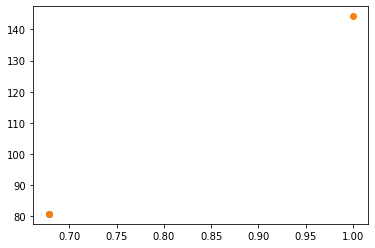

49 176
Age from 49.0 to 112.5 crossings k= 30 of n= 91
Age from 112.5 to 176.0 crossings k= 5 of n= 12


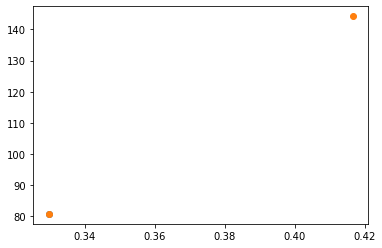

49 176
Age from 49.0 to 112.5 crossings k= 6 of n= 14
Age from 112.5 to 176.0 crossings k= 1 of n= 3


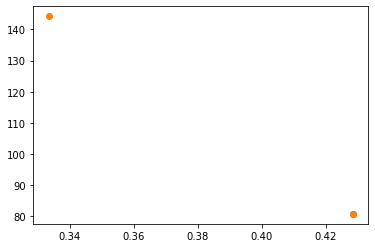

In [19]:
# filter to a stim layer and bin by age
only_stim_layer = "L2/3"
for only_stim_layer in ['L2/3', "L4", "L5"]:
    df2 = df[df['Stim Location'].str.contains(only_stim_layer)]
    n_bins = 2
    min_age = df['Age'].min()
    max_age = df['Age'].max()
    print(min_age, max_age)
    bin_size = (max_age - min_age) / n_bins
    ks =[]
    ns = []
    bins = []
    for i in range(n_bins):
        bin_min = min_age + i * bin_size
        bin_max = bin_min + bin_size
        df_bin = df2[df2["Age"].between(bin_min, bin_max)]

        n_barrel_cross = len(df_bin[df_bin['# crossings 2/3'] > 0])
        n_barrel_cross += len(df_bin[df_bin['# crossings 1/2'] > 0])
        n_total = n_barrel_cross + len(df_bin[df_bin['# no crossings 2/3'] > 0])
        n_total += len(df_bin[df_bin['# no crossings 1/2'] > 0])
        print("Age from", bin_min, 'to', bin_max, 'crossings k=', n_barrel_cross,
              "of n=", n_total)
        if n_total > 0:
            ks.append(n_barrel_cross)
            ns.append(n_total)
            bins.append([bin_min, bin_max])

        # plot
        ps = [ks[i] / ns[i] for i in range(len(ks))]
        bin_midpoint = [(b[0] + b[1]) / 2 for b in bins]
        plt.scatter(ps, bin_midpoint)

    plt.show()

In [20]:
n_young = [59, 91, 14]
n_old = [6,12,3]
young_p_crossing = [40, 30, 6]
old_p_crossing = [6,5,1]

for i in range(3):
    n_m = n_young[i]
    n_f = n_old[i]
    p_m = young_p_crossing[i] / 100
    p_f = old_p_crossing[i] / 100
    p = (n_m * p_m + n_f * p_f) / (n_m + n_f)
    den = np.sqrt(p * (1-p) * (1/n_m + 1 / n_f))
    Z = (p_m - p_f) / den
    p_value = norm.sf(abs(Z)) * 2 # two-tailed test
    print(["L2/3", "L4", "L5"][i], ": Z=", Z, "p-value:", p_value)

L2/3 : Z= 1.6447130693690493 p-value: 0.10002899634424992
L4 : Z= 1.831672689491784 p-value: 0.06700019989606773
L5 : Z= 0.35665005901562435 p-value: 0.721353796987567
